In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
eps = 0.03
Attack = 'fgsm'

In [7]:
!pip install foolbox
import foolbox as fb
import os
import math
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import torch.optim as optim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [61]:
model = torchvision.models.vgg16(pretrained=True)
print("Loaded pretrained vgg-16 model")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded pretrained vgg-16 model


In [62]:
model = model.eval()
print("model in eval mode")

model in eval mode


In [63]:
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)

In [64]:
fmodel = fmodel.transform_bounds((0, 1))
assert fmodel.bounds == (0, 1)

In [65]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

In [66]:
acc = fb.utils.accuracy(fmodel, images, labels)
print("accuracy of the model on clean images: ", acc)

accuracy of the model on clean images:  0.875


In [67]:
print("images.type: ",type(images), 'images.shape: ',images.shape)
print("images.type: ",type(labels), 'images.shape: ',labels.shape)

images.type:  <class 'torch.Tensor'> images.shape:  torch.Size([16, 3, 224, 224])
images.type:  <class 'torch.Tensor'> images.shape:  torch.Size([16])


In [73]:
if Attack == 'fgsm' : attack = fb.attacks.FGSM()
if Attack == 'deepfool': attack = fb.attacks.LinfDeepFoolAttack()
if Attack == 'cw': attack = fb.attacks.L2CarliniWagnerAttack()
if Attack == 'pgd': attack=fb.attacks.L2PGD()
if Attack == 'bim': attack = fb.attacks.L2BasicIterativeAttack()
print(attack)

LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)


In [76]:
criterion = fb.criteria.Misclassification(labels)
raw, clipped, is_adv = attack(fmodel, images, criterion, epsilons=eps)
print("is adversarial: ", is_adv)
print('l2 distance: ', fb.distances.l2(images, raw))


import numpy as np
import eagerpy as ep
images = ep.astensor(images)
labels = ep.astensor(labels)

print("accuracy as a function of epsiolon: ")
epsilons = np.linspace(0.0, 0.005, num=20)
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
print("adversarial shape: ", is_adv.shape)
print("is adversarial: ", is_adv.float32().mean(axis=-1))
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
print("robust accuracy = ", robust_accuracy )
import matplotlib.pyplot as plt
plt.plot(epsilons, robust_accuracy.numpy())

plotting clean images: 
plotting adversarial images: 
plotting noise for four images: 


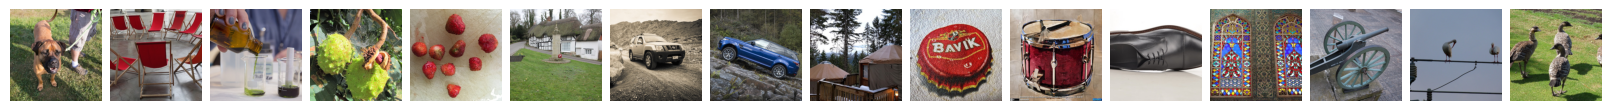

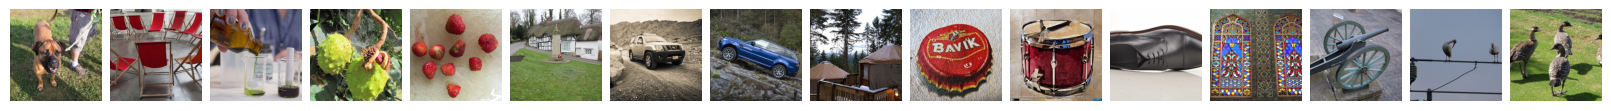

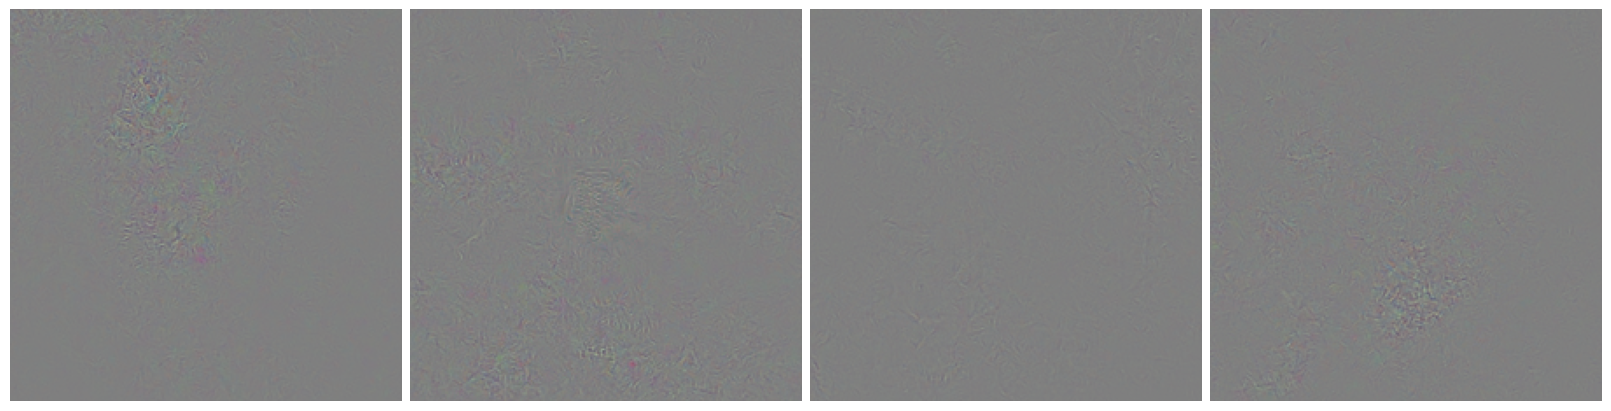

In [71]:
print("plotting clean images ")
fb.plot.images(images)
print("plotting adversarial images ")
fb.plot.images(advs)
print("plotting noise for four images ")
fb.plot.images(advs - images, n=4, bounds=(-0.1, 0.1), scale=4.)